# Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import random as rd
import os
from tqdm import tqdm
import tensorflow_addons as tfa
import pandas as pd
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar


plt.style.use(['science','ieee'])

2022-06-06 19:46:49.721107: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-06 19:46:49.721161: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Oracle

In [2]:
#GeV [min,max]

M1_range = M2_range = M3_range = [50, 5000]
mA_range = [50, 5000]
tanB_range = [2, 60]
mu_range = [-10**4, 10**4]
At_range = Ab_range = Atau_range = [-10**4, 10**4]
Mq1L_range = Mq3L_range = [50, 5000]
MuR_range = MdR_range = MtR_range = MbR_range = [50, 5000]
MeL_range = MtauL_range = MeR_range = MtauR_range = [50, 5000]

PMSSM_range_big= [M1_range, M2_range, M3_range, mA_range, tanB_range, mu_range, At_range, Ab_range, 
              Atau_range, Mq1L_range, Mq3L_range, MuR_range, MdR_range, MtR_range, MbR_range,
             MeL_range, MtauL_range, MeR_range, MtauR_range]

PMSSM_min = np.array([i[0] for i in PMSSM_range_big])
PMSSM_max = np.array([i[1] for i in PMSSM_range_big])

PMSSM_sub = np.subtract(PMSSM_max, PMSSM_min)

PMSSM_range = [PMSSM_min,PMSSM_max,PMSSM_sub]

In [3]:
def write_slha(PMSSM_NN, nom_slha):
    f = open(nom_slha, "w")
    
    f.write("BLOCK MODSEL \n")
    f.write(" 1    0              #MSSM \n")
    
    f.write("BLOCK SMINPUTS \n")
    f.write("  1   1.279340000e+02     # alpha^(-1) SM MSbar(M1) \n")
    f.write("  2   1.663700000e-05     # G_Fermi \n")
    f.write("  3   0.1179              # alphas(MS) SM MSbar \n")
    f.write("  4   91.1876             # MZ(pole) \n")
    f.write("  5   4.18                # mb(mb) SM MSbar \n")
    f.write("  6   172.9               # mtop(pole) \n")
    f.write("  7   1.776860000e+00     #m mtau(pole) \n")
    
    f.write("BLOCK MINPAR \n")
    f.write("  3   "+str(PMSSM_NN[4])+"   #tanb \n")
    
    f.write("BLOCK VCKMIN   #CKM param (Wolfenstein) \n")
    f.write("  1   0.22650  #lambda \n")
    f.write("  2   0.790    #A \n")
    f.write("  3   0.141    #rho \n")
    f.write("  4   0.357    #eta \n")
    
    f.write("BLOCK EXTPAR \n")
    f.write("  0   "+str(-1.0)+"               # Q \n")
    f.write("  1   "+str(PMSSM_NN[0])+"        # M1 \n")
    f.write("  2   "+str(PMSSM_NN[1])+"        # M2 \n")
    f.write("  3   "+str(PMSSM_NN[2])+"        # M3 \n")
    f.write("  11   "+str(PMSSM_NN[6])+"       # At \n")
    f.write("  12   "+str(PMSSM_NN[7])+"       # Ab \n")
    f.write("  13   "+str(PMSSM_NN[8])+"       # Atau \n")
    f.write("  23   "+str(PMSSM_NN[5])+"       # Mu \n")
    f.write("  26   "+str(PMSSM_NN[3])+"       # Ma \n")
    f.write("  31   "+str(PMSSM_NN[15])+"      # MeL \n")
    f.write("  32   "+str(PMSSM_NN[15])+"      # MmuL \n")
    f.write("  33   "+str(PMSSM_NN[16])+"      # MstauL \n")
    f.write("  34   "+str(PMSSM_NN[17])+"      # MeR \n")
    f.write("  35   "+str(PMSSM_NN[17])+"      # MmuR \n")
    f.write("  36   "+str(PMSSM_NN[18])+"      # MstauR \n")
    f.write("  41   "+str(PMSSM_NN[9])+"       # Mq1L \n")
    f.write("  42   "+str(PMSSM_NN[9])+"       # Mq2L \n")
    f.write("  43   "+str(PMSSM_NN[10])+"      # Mq3L \n")
    f.write("  44   "+str(PMSSM_NN[11])+"      # MquR \n")
    f.write("  45   "+str(PMSSM_NN[11])+"      # MqcR \n")
    f.write("  46   "+str(PMSSM_NN[13])+"      # MqtR \n")
    f.write("  47   "+str(PMSSM_NN[12])+"      # MqdR \n")
    f.write("  48   "+str(PMSSM_NN[12])+"      # MqsR \n")
    f.write("  49   "+str(PMSSM_NN[14])+"      # MqbR \n")
    
    f.close()

In [4]:
def Oracle(logits, PMSSM_range, ratio, succes_path):
    
    PMSSM_AL = np.add(np.multiply(logits,PMSSM_range[2]),PMSSM_range[0])
    
    write_slha(PMSSM_AL, "Advanced NN/AL/pmssm_al.in")    
    
    os.system('./SUSY/softsusy-4.1.9/softpoint.x leshouches < Advanced\ NN/AL/pmssm_al.in > Advanced\ NN/AL/pmssm_al.out')
            
          
    if os.path.getsize('/home/mathis/Stage M1/Advanced NN/AL/pmssm_al.out') == 0 :
        ratio[0]+=1
        return 0
        
    with open('Advanced NN/AL/pmssm_al.out') as slha_out:
        content = slha_out.read()
        if 'SOFTSUSY problem' in content:
            ratio[0]+=1
            return 0
        if 'LSP # Warning' in content:
            ratio[0]+=1
            return 0
    
    
    
    ratio[1]+=1
    commande = 'mv Advanced\ NN/AL/pmssm_al.out '
    nom_fichier = 'pmssm_al_succes_'+str(ratio[1])+'.out'
    os.system(commande+succes_path+nom_fichier)
    return 1   

# Model

In [5]:
fnc_activation = 'relu'
fnc_activation_output = 'sigmoid'
inputs = tf.keras.Input(shape=(19,), dtype='float32')
x = keras.layers.Dense(100, trainable=True, activation=fnc_activation)(inputs)
x = keras.layers.Dense(100, trainable=True, activation=fnc_activation)(x)
outputs = keras.layers.Dense(1, activation=fnc_activation_output)(x)
model = tf.keras.Model(inputs,outputs)

lr = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

model.summary()



loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction='sum_over_batch_size')
#False pour une probabilité ie [0;1]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19)]              0         
                                                                 
 dense (Dense)               (None, 100)               2000      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 12,201
Trainable params: 12,201
Non-trainable params: 0
_________________________________________________________________


2022-06-06 19:46:53.233305: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-06 19:46:53.233338: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-06 19:46:53.233359: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (MPC): /proc/driver/nvidia/version does not exist
2022-06-06 19:46:53.233584: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Initial training

In [6]:
os.chdir('/home/mathis/Stage M1/')
os.system('rm -r Advanced\ NN/AL/softsusy_succes_IT/')
os.system('mkdir -p Advanced\ NN/AL/softsusy_succes_IT')
succes_path_IT = 'Advanced\ NN/AL/softsusy_succes_IT/'

ratio_IT = [0,0]

L_size = 500000
K_size = 1000
train_step = 50

a = 0.0001
alpha = 0.5

K_pool = []
K_pred = []

compteur = 0
full_train = 0

q = 1

for step , i in enumerate(range(train_step)):
    print('Step {} / {}'.format(i+1,train_step))
    
    p = 2*min(q,0.5)
    p = round(p,1)
    
    if p == 1:
        K = [[rd.uniform(0,1) for j in range(19)] for k in range(K_size)]
    
    if p < 1:
        print('   Recherche points')
        pK_size = int(K_size*p)
        pm1 = round((1-p),1)
        
        pK = [[rd.uniform(0,1) for j in range(19)] for k in range(pK_size)]
        
        L = [[rd.uniform(0,1) for j in range(19)] for k in range(L_size)]
        L = tf.convert_to_tensor(L)
        L_logits = model(tf.convert_to_tensor(L))

        s = tf.math.multiply(L_logits,tf.math.subtract(1,L_logits))
        index = tf.math.argmax(s, axis=0).numpy()[0]

        K = []
        K.append(L[index].numpy().tolist())
        s = tf.concat([s[0:index], s[index+1:len(s)]],0)
        L = tf.concat([L[0:index], L[index+1:len(L)]],0)


        rj_tensor = tf.zeros([len(s),1])
        for j in range(int(pm1*K_size)-1):

            ri = tf.convert_to_tensor(K[-1])
            ri = tf.math.multiply(tf.ones([len(s),1]),ri)

            dabs = tf.math.abs(tf.math.subtract(ri,L))
            dsquared = tf.math.multiply(dabs, dabs)
            dsquared = tf.reduce_mean(dsquared, axis=1)

            rj_list = dsquared.numpy()
            rj_list = np.where(rj_list<0.01**2, -a/(a+rj_list), rj_list*0)
            rj_min = np.amin(rj_list)

            rj_list = tf.convert_to_tensor([rj_list])
            rj_list = tf.transpose(rj_list)
            rj_tensor = tf.math.add(rj_tensor,rj_list)

            sigma = s.numpy().std() 

            S_part1 = tf.math.multiply((1-alpha),s)
            S_part2 = tf.math.multiply((alpha*sigma/(4*rj_min)),rj_tensor)
            S = tf.math.add(S_part1 , S_part2)

            index2 = tf.math.argmax(S, axis=0).numpy()[0]

            K.append(L[index2].numpy().tolist())

            s = tf.concat([s[0:index2], s[index2+1:len(s)]],0)
            L = tf.concat([L[0:index2], L[index2+1:len(L)]],0)
            rj_tensor = tf.concat([rj_tensor[0:index2], rj_tensor[index2+1:len(rj_tensor)]],0)
        
        K = K + pK
        
    assert len(K) == K_size
    K_pool.append(K)
    
    pred_liste = []
    print('   Verite')
    for j in tqdm(K):
        pred = Oracle(j, PMSSM_range, ratio_IT, succes_path_IT)
        pred_liste.append(pred)
    
    assert len(pred_liste) == K_size
    K_pred.append(pred_liste)     
    
    batch_pred = [K_pred[-1]]
    all_batch = [K_pool[-1]]
    '''
    if compteur == full_train:
        compteur = 0
        all_batch = K_pool
        batch_pred = K_pred
    '''
    
    print('   Optimisation')
    for j in range(len(all_batch)): 
        with tf.GradientTape() as tape:
            logits = model(tf.convert_to_tensor(all_batch[j]))

            true = tf.convert_to_tensor([batch_pred[j]])
            true = tf.transpose(true)
            
            true_prime = tf.cast(true, dtype=tf.float32)
            q = tf.math.abs(tf.math.subtract(true_prime,logits))
            q = tf.reduce_mean(q, axis=0)
            q = round(q.numpy()[0],1)
            
            loss = loss_fn(true,logits)

        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    compteur += 1
    
    
print("Nombre d'échecs:",ratio_IT[0])
print("Nombre de succes:",ratio_IT[1])

Step 1 / 50
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:41<00:00,  9.88it/s]


   Optimisation
Step 2 / 50
   Recherche points


/tmp/ipykernel_948510/1837296023.py:73: RuntimeWarning: divide by zero encountered in double_scalars
  S_part2 = tf.math.multiply((alpha*sigma/(4*rj_min)),rj_tensor)


   Verite


100%|███████████████████████████████████████| 1000/1000 [01:51<00:00,  8.99it/s]


   Optimisation
Step 3 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:40<00:00,  9.91it/s]


   Optimisation
Step 4 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:36<00:00, 10.36it/s]


   Optimisation
Step 5 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:48<00:00,  9.20it/s]


   Optimisation
Step 6 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:41<00:00,  9.86it/s]


   Optimisation
Step 7 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:40<00:00,  9.91it/s]


   Optimisation
Step 8 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:40<00:00,  9.97it/s]


   Optimisation
Step 9 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:45<00:00,  9.47it/s]


   Optimisation
Step 10 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:46<00:00,  9.36it/s]


   Optimisation
Step 11 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:36<00:00, 10.37it/s]


   Optimisation
Step 12 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:26<00:00, 11.58it/s]


   Optimisation
Step 13 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:33<00:00, 10.64it/s]


   Optimisation
Step 14 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:35<00:00, 10.44it/s]


   Optimisation
Step 15 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:40<00:00,  9.91it/s]


   Optimisation
Step 16 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:30<00:00, 10.99it/s]


   Optimisation
Step 17 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:29<00:00, 11.18it/s]


   Optimisation
Step 18 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:29<00:00, 11.20it/s]


   Optimisation
Step 19 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:31<00:00, 10.87it/s]


   Optimisation
Step 20 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:47<00:00,  9.27it/s]


   Optimisation
Step 21 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:34<00:00, 10.55it/s]


   Optimisation
Step 22 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:30<00:00, 11.00it/s]


   Optimisation
Step 23 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:35<00:00, 10.43it/s]


   Optimisation
Step 24 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:27<00:00, 11.48it/s]


   Optimisation
Step 25 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:40<00:00,  9.92it/s]


   Optimisation
Step 26 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:45<00:00,  9.48it/s]


   Optimisation
Step 27 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:37<00:00, 10.21it/s]


   Optimisation
Step 28 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:41<00:00,  9.89it/s]


   Optimisation
Step 29 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:45<00:00,  9.46it/s]


   Optimisation
Step 30 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:40<00:00,  9.92it/s]


   Optimisation
Step 31 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:47<00:00,  9.34it/s]


   Optimisation
Step 32 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:48<00:00,  9.21it/s]


   Optimisation
Step 33 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:42<00:00,  9.79it/s]


   Optimisation
Step 34 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:43<00:00,  9.62it/s]


   Optimisation
Step 35 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:45<00:00,  9.50it/s]


   Optimisation
Step 36 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:40<00:00,  9.96it/s]


   Optimisation
Step 37 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:38<00:00, 10.12it/s]


   Optimisation
Step 38 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:34<00:00, 10.63it/s]


   Optimisation
Step 39 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:27<00:00, 11.41it/s]


   Optimisation
Step 40 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:32<00:00, 10.82it/s]


   Optimisation
Step 41 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:41<00:00,  9.83it/s]


   Optimisation
Step 42 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:45<00:00,  9.52it/s]


   Optimisation
Step 43 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:38<00:00, 10.13it/s]


   Optimisation
Step 44 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:43<00:00,  9.64it/s]


   Optimisation
Step 45 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:41<00:00,  9.90it/s]


   Optimisation
Step 46 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:36<00:00, 10.42it/s]


   Optimisation
Step 47 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:50<00:00,  9.04it/s]


   Optimisation
Step 48 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:42<00:00,  9.78it/s]


   Optimisation
Step 49 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:32<00:00, 10.84it/s]


   Optimisation
Step 50 / 50
   Recherche points
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:38<00:00, 10.16it/s]

   Optimisation
Nombre d'échecs: 44954
Nombre de succes: 5046


# Récupération data

In [7]:
def recuperation_slha(folder,filename,sus_mass,param,succes):
    warning = 0
    for j in range(succes):
        file_name =folder+filename+str(j+1)+'.out' 
        
        with open(file_name) as file:
            for indice, ligne in enumerate(file):
                if 'tanb' in ligne:
                    indice_tanb = indice
                
                if 'M_1(MX)' in ligne:
                    indices_M = [indice+i for i in range(3)]
                if 'At(MX)' in ligne:
                    indices_A = [indice+i for i in range(3)]
                if 'mu(MX)' in ligne:
                    indice_mu = indice
                if 'mA(pole)' in ligne:
                    indice_mA = indice
                if 'meL(MX)' in ligne:
                    indices_mlL = [indice+i for i in range(3)]
                if 'meR(MX)' in ligne:
                    indices_mlR = [indice+i for i in range(3)]
                if 'mqL1(MX)' in ligne:
                    indices_qL = [indice+i for i in range(3)]
                if 'muR(MX)' in ligne:
                    indices_q = [indice+i for i in range(6)]
                    
                if 'h0' in ligne:
                    indices_higgs = [indice+i for i in range(2)]
                if '~g' in ligne:
                    indice_g = indice
                if '~neutralino(1)' in ligne:
                    indices_neutralino = [indice,indice+1,indice+3,indice+4]
                if '~d_L' in ligne:
                    indices_squarkL = [indice+i for i in range(6)]
                if '~d_R' in ligne:
                    indices_squarkR = [indice+i for i in range(6)]
                if '~chargino(1)' in ligne:
                    indices_chargino = [indice,indice+3]
        
        
        file = open(file_name)
        lignes = file.readlines()
        
        for step, i in enumerate(param[0]):
            i.append(float(lignes[indices_M[step]].split()[1]))

        for step, i in enumerate(param[1]):
            i.append(float(lignes[indices_A[step]].split()[1]))  
            
        param[2].append(float(lignes[indice_mu].split()[1]))
        
        param[3].append(float(lignes[indice_mA].split()[1]))
        
        for step, i in enumerate(param[4]):
            i.append(float(lignes[indices_mlL[step]].split()[1]))
            
        for step, i in enumerate(param[5]):
            i.append(float(lignes[indices_mlR[step]].split()[1]))
            
        for step, i in enumerate(param[6]):
            i.append(float(lignes[indices_qL[step]].split()[1]))
        
        for step, i in enumerate(param[7]):
            i.append(float(lignes[indices_q[step]].split()[1]))
            
        param[8].append(float(lignes[indice_tanb].split()[1]))
            
        
        sus_mass[0].append(float(lignes[indice_g].split()[1]))
        
        for step, i in enumerate(sus_mass[1]):
            i.append(float(lignes[indices_neutralino[step]].split()[1]))
            
        for step, i in enumerate(sus_mass[2]):
            i.append(float(lignes[indices_squarkL[step]].split()[1]))

        for step, i in enumerate(sus_mass[3]):
            i.append(float(lignes[indices_squarkR[step]].split()[1]))
        
        for step, i in enumerate(sus_mass[4]):
            i.append(float(lignes[indices_higgs[step]].split()[1]))

        for step, i in enumerate(sus_mass[5]):
            i.append(float(lignes[indices_chargino[step]].split()[1]))        
    
    
        with open(file_name) as file:
            if 'LSP # Warning' in file.read():
                warning+=1
    return warning

In [8]:
g_mass = []
neutralino_mass = [[] for i in range(4)]   #[N1 , N2 , N3 , N4]
squarkL_mass = [[] for i in range(6)]      #[d , u , s , c , b , t]
squarkR_mass = [[] for i in range(6)]       
higgs_mass = [[] for i in range(2)]        #[h0 , H0]
chargino_mass = [[] for i in range(2)]     #[neutralino1 , neutralino2]

M_param = [[] for i in range(3)]           #[M1 , M2 , M3]
A_param = [[] for i in range(3)]           #[At , Ab , Atau]
mu = []
mA_param = []
mlL_param = [[] for i in range(3)]         #[meL , mmuL , mtauL]
mlR_param = [[] for i in range(3)]         #[meR , mmuR , mtauR]
mqL_param = [[] for i in range(3)]         #[mqL1 , mqL2 , mqL3]
quark_param = [[] for i in range(6)]       #[u , c , t , d , s , b]
tanB = []

sus_mass = [g_mass,neutralino_mass,squarkL_mass,squarkR_mass,higgs_mass,chargino_mass]
param = [M_param,A_param,mu,mA_param,mlL_param,mlR_param,mqL_param,quark_param,tanB]

folder = 'Advanced NN/AL/softsusy_succes_IT/'
file_name = 'pmssm_al_succes_'
warning = recuperation_slha(folder,file_name,sus_mass,param,ratio_IT[1])

print('Nombre warning:',warning)

Nombre warning: 0


# Sauvegarde Run

In [9]:
from datetime import date, datetime

folder_name = str(date.today())+'-'+str(datetime.now().time().strftime("%H:%M:%S"))
commande = 'mkdir -p Advanced\ NN/AL/AL_run/'+folder_name
os.system(commande)

with open('Advanced NN/AL/AL_run/'+folder_name+'/config.txt', 'w') as f:
    f.write('L: '+str(L_size)+'\n')
    f.write('K: '+str(K_size)+'\n')
    f.write('alpha: '+str(alpha)+'\n')
    f.write('a: '+str(a)+'\n')
    f.write('train steps: '+str(train_step)+'\n')
    f.write("Nombre d'échecs: "+str(ratio_IT[0])+'\n')
    f.write("Nombre de succes: "+str(ratio_IT[1])+'\n')
    f.write("Nombre Warning LSP: "+str(warning)+'\n')
    f.write('\n')
    f.write("Fonctions d'activations: "+fnc_activation+'\n')
    f.write("Fonctions d'activations output: "+fnc_activation_output+'\n')
    f.write('Learning rate:'+str(lr)+'\n')
    f.write('Optimizer: '+str(optimizer)+'\n')
    f.write('\n')
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    f.write('\n')
    f.write('\n')
    f.write('Range:')
    f.write('M1: '+str(PMSSM_range_big[0])+'\n')
    f.write('M2: '+str(PMSSM_range_big[1])+'\n')
    f.write('M3: '+str(PMSSM_range_big[2])+'\n')
    f.write('mA: '+str(PMSSM_range_big[3])+'\n')
    f.write('tanB: '+str(PMSSM_range_big[4])+'\n')
    f.write('mu: '+str(PMSSM_range_big[5])+'\n')
    f.write('At: '+str(PMSSM_range_big[6])+'\n')
    f.write('Ab: '+str(PMSSM_range_big[7])+'\n')
    f.write('Atau: '+str(PMSSM_range_big[8])+'\n')
    f.write('Mq1L: '+str(PMSSM_range_big[9])+'\n')
    f.write('Mq3L: '+str(PMSSM_range_big[10])+'\n')
    f.write('MuR: '+str(PMSSM_range_big[11])+'\n')
    f.write('dR: '+str(PMSSM_range_big[12])+'\n')
    f.write('MtR: '+str(PMSSM_range_big[13])+'\n')
    f.write('MbR: '+str(PMSSM_range_big[14])+'\n')
    f.write('MeL: '+str(PMSSM_range_big[15])+'\n')
    f.write('MtauL: '+str(PMSSM_range_big[16])+'\n')
    f.write('MeR: '+str(PMSSM_range_big[17])+'\n')
    f.write('MtauR: '+str(PMSSM_range_big[18])+'\n')
    

model.save('Advanced NN/AL/AL_run/'+folder_name+'/model.h5')
    
param_file = zip(M_param[0],M_param[1],M_param[2],A_param[0],A_param[1],A_param[2],mu,mA_param,
                 mlL_param[0],mlL_param[1],mlL_param[2],mlR_param[0],mlR_param[2],mlR_param[2],
                 mqL_param[0],mqL_param[1],mqL_param[2],quark_param[0],quark_param[1],quark_param[2],
                 quark_param[3],quark_param[4],quark_param[5],tanB)

header = ['M1', 'M2', 'M3', 'At', 'Ab', 'Atau', 'mu', 'mA', 'meL', 'mmuL', 'mtauL', 'meR', 'mmuR', 'mtauR', 'mqL1', 'mqL2', 'mqL3', 'muR', 'mcR', 'mtR', 'mdR', 'msR', 'mbR', 'tanb']

import csv
with open('Advanced NN/AL/AL_run/'+folder_name+'/data.csv', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerow(header)
    writer.writerows(param_file)

K_file = []

for indice_i,i in enumerate(K_pool):
    for indice_j,j in enumerate(i):
        K_file.append(j+[K_pred[indice_i][indice_j]])

with open('Advanced NN/AL/AL_run/'+folder_name+'/K_pool.csv', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerow(header+['pred'])
    writer.writerows(K_file)

# Plot 

In [10]:
def plot_histo(title, xlabel, ylabel, list_hist,bins, label, legend = False, histtype='bar', save=False, file_folder=''):
    plt.figure()
    for indice, hist in enumerate(list_hist):
        plt.hist(hist,bins,label=label[indice],histtype=histtype)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend == True:
        plt.legend()
    if save == True:
        plt.savefig(file_folder)
    
def subplot_histo(titre, xlabel, ylabel, x, y, share, subtitle, hist_list, label, legend = False, histtype='bar', save=False, file_folder=''):  
    fig , ax = plt.subplots(x, y, sharex=share[0], sharey=share[1], constrained_layout = True)
    plt.suptitle(titre)
    fig.text(0.5, -0.05, xlabel, ha='center')
    fig.text(-0.04, 0.5, ylabel, va='center', rotation='vertical')

    for indice, hist in enumerate(hist_list): 
        compteur = 0
        for i in range(x):
            if y != 1:
                for j in range(y):
                    ax[i, j].hist(hist[compteur],100,histtype=histtype,label=label[indice])
                    ax[i, j].set_title(subtitle[compteur])
                    compteur+=1
                    if legend == True:
                        ax[i, j].legend()
            else:
                ax[i].hist(hist[compteur],100,histtype=histtype, label=label[indice])
                ax[i].set_title(subtitle[compteur])
                compteur+=1
                if legend == True:
                    ax[i].legend()
    if save == True:
        plt.savefig(file_folder)

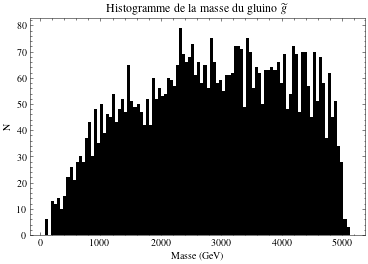

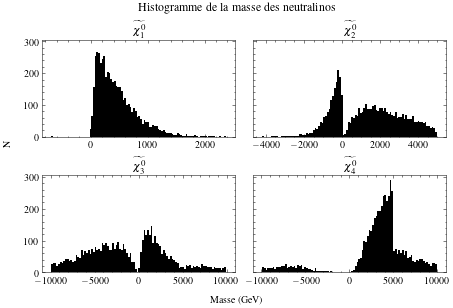

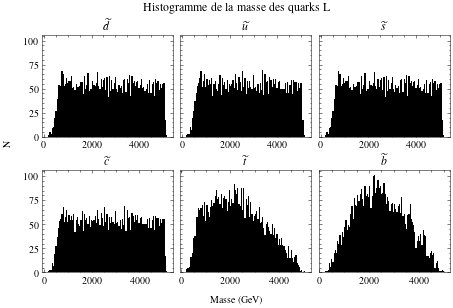

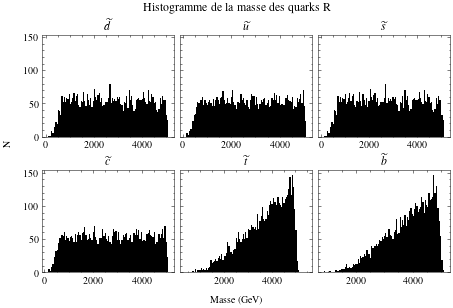

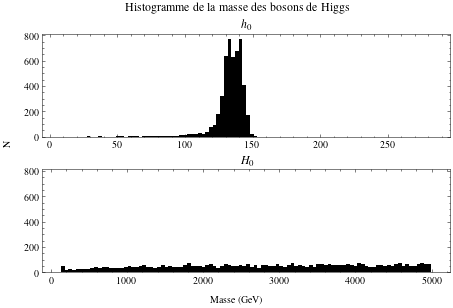

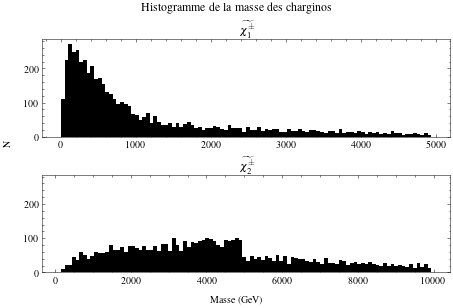

In [11]:
folder = 'Advanced NN/AL/AL_run/'+folder_name

file = '/histo_gluinos.svg'
titre = r'Histogramme de la masse du gluino $\widetilde{g}$'
xlabel = 'Masse (GeV)'
ylabel = 'N'
plot_histo(titre,xlabel,ylabel,[g_mass],100,['NN'],save=True,file_folder=folder+file)

file = '/histo_neutralinos.svg'
titre = 'Histogramme de la masse des neutralinos'
subtitle = [r'$\widetilde{\chi_1^0}$',r'$\widetilde{\chi_2^0}$',r'$\widetilde{\chi_3^0}$',r'$\widetilde{\chi_4^0}$']
share = [False,True]
subplot_histo(titre,xlabel,ylabel,2,2,share,subtitle,[neutralino_mass],['NN'],save=True,file_folder=folder+file)

file = '/histo_quarksL.svg'
titre = 'Histogramme de la masse des quarks L'
subtitle = [r'$\widetilde{d}$',r'$\widetilde{u}$',r'$\widetilde{s}$',r'$\widetilde{c}$',r'$\widetilde{t}$',r'$\widetilde{b}$']    
subplot_histo(titre,xlabel,ylabel,2,3,share,subtitle,[squarkL_mass],['NN'],save=True,file_folder=folder+file)

file = '/histo_quarksR.svg'
titre = 'Histogramme de la masse des quarks R' 
subplot_histo(titre,xlabel,ylabel,2,3,share,subtitle,[squarkR_mass],['NN'],save=True,file_folder=folder+file)

file = '/histo_higgs.svg'
titre = 'Histogramme de la masse des bosons de Higgs'    
subtitle = [r'$h_0$',r'$H_0$']
subplot_histo(titre,xlabel,ylabel,2,1,share,subtitle,[higgs_mass],['NN'],save=True,file_folder=folder+file)

file = '/histo_charginos.svg'
titre = 'Histogramme de la masse des charginos'    
subtitle = [r'$\widetilde{\chi_1^\pm}$',r'$\widetilde{\chi_2^\pm}$']
subplot_histo(titre,xlabel,ylabel,2,1,share,subtitle,[chargino_mass],['NN'],save=True,file_folder=folder+file)

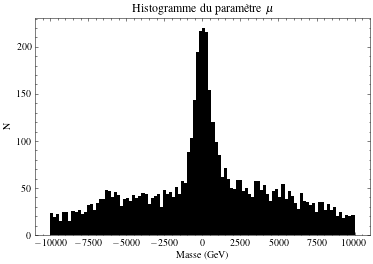

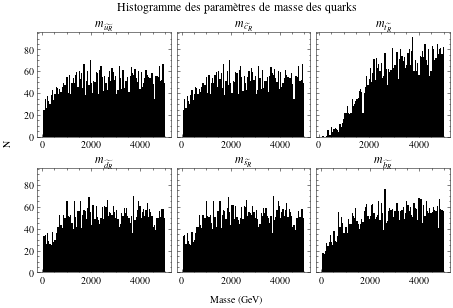

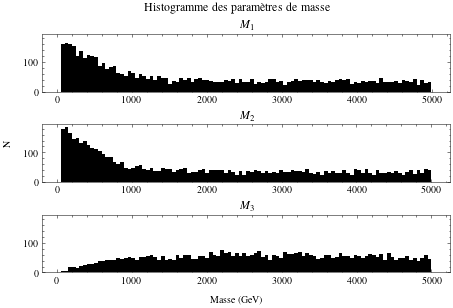

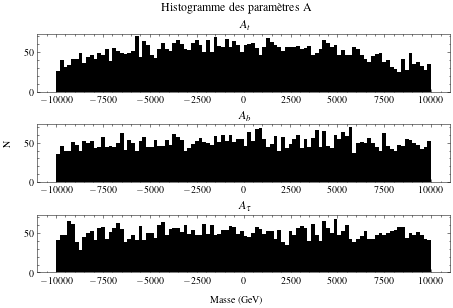

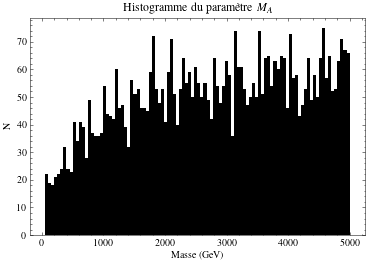

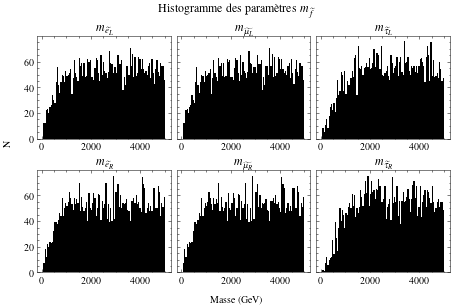

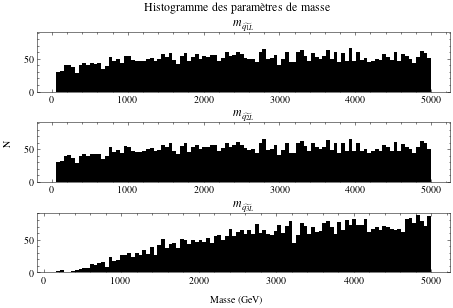

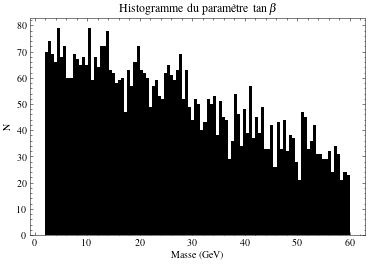

In [12]:
file = '/histo_mu.svg'
titre = r'Histogramme du paramètre $\mu$'
plot_histo(titre,xlabel,ylabel,[mu],100,['NN'],save=True,file_folder=folder+file)

file = '/histo_mquarks.svg'
titre = 'Histogramme des paramètres de masse des quarks'
subtitle = [r'$m_{\widetilde{u_R}}$',r'$m_{\widetilde{c_R}}$',r'$m_{\widetilde{t_R}}$',r'$m_{\widetilde{d_R}}$',r'$m_{\widetilde{s_R}}$',r'$m_{\widetilde{b_R}}$']
subplot_histo(titre,xlabel,ylabel,2,3,share,subtitle,[quark_param],['NN'],save=True,file_folder=folder+file)

file = '/histo_M.svg'
titre = 'Histogramme des paramètres de masse'
subtitle = [r'$M_1$',r'$M_2$',r'$M_3$']
subplot_histo(titre,xlabel,ylabel,3,1,share,subtitle,[M_param],['NN'],save=True,file_folder=folder+file)

file = '/histo_A.svg'
titre = 'Histogramme des paramètres A'
subtitle = [r'$A_t$',r'$A_b$',r'$A_\tau$']
subplot_histo(titre,xlabel,ylabel,3,1,share,subtitle,[A_param],['NN'],save=True,file_folder=folder+file)

file = '/histo_mA.svg'
titre = r'Histogramme du paramètre $M_A$'
plot_histo(titre,xlabel,ylabel,[mA_param],100,['NN'],save=True,file_folder=folder+file)

file = '/histo_mlL.svg'
titre = r'Histogramme des paramètres $m_{\widetilde{f}}$'
subtitle = [r'$m_{\widetilde{e_L}}$',r'$m_{\widetilde{\mu_L}}$',r'$m_{\widetilde{\tau_L}}$',r'$m_{\widetilde{e_R}}$',r'$m_{\widetilde{\mu_R}}$',r'$m_{\widetilde{\tau_R}}$']
subplot_histo(titre,xlabel,ylabel,2,3,share,subtitle,[mlL_param+mlR_param],['NN'],save=True,file_folder=folder+file)

file = '/histo_mqL.svg'
titre = 'Histogramme des paramètres de masse'
subtitle = [r'$m_{\widetilde{q_{1L}}}$',r'$m_{\widetilde{q_{2L}}}$',r'$m_{\widetilde{q_{3L}}}$']
subplot_histo(titre,xlabel,ylabel,3,1,share,subtitle,[mqL_param],['NN'],save=True,file_folder=folder+file)

file = '/histo_tanb.svg'
titre = r'Histogramme du paramètre $\tan \beta$'
plot_histo(titre,xlabel,ylabel,[tanB],100,['NN'],save=True,file_folder=folder+file)

In [13]:
print('Statisique du Neural Network')
print("Nombre d'échecs:",ratio_IT[0])
print("Nombre de succes:",ratio_IT[1])
print('Nombre warning:', warning)
print('Éfficacité du AL:',100*ratio_IT[1]/(ratio_IT[0]+ratio_IT[1]),'%')
print('\n')

Statisique du Neural Network
Nombre d'échecs: 44954
Nombre de succes: 5046
Nombre warning: 0
Éfficacité du AL: 10.092 %


